In [20]:
import easyocr
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.transform import rotate
from skimage.color import rgb2gray
from deskew import determine_skew

In [21]:
def display(image):
    dpi = 80
    height, width  = image.shape[:2]
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(image, cmap='gray')
    plt.show()

def deskew_image(image):
    grayscale = rgb2gray(image)
    angle = determine_skew(grayscale)
    rotated = rotate(image, angle, resize=True) * 255
    return rotated.astype(np.uint8)

def detect_and_crop_rectangular_page(image):
    original = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(gray, 50, 150)
    contours, _ = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            cv2.drawContours(original, [approx], -1, (0, 255, 0), 3)
            x, y, w, h = cv2.boundingRect(approx)
            cropped_image = image[y:y+h, x:x+w]
            display(original)
            display(cropped_image)
            return cropped_image
    print("No rectangular page detected.")
    return None

In [47]:
def detect_and_crop_rectangular_pages(image):
    original = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(gray, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # List to hold cropped rectangles and their dimensions
    cropped_images = []
    dimensions = []

    # Iterate over each contour
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Check if the contour is a rectangle (has 4 sides)
        if len(approx) == 4:
            # Draw the contour on the original image
            cv2.drawContours(original, [approx], -1, (0, 255, 0), 3)

            # Get the bounding box of the contour
            x, y, w, h = cv2.boundingRect(approx)

            # Crop the rectangle
            cropped_image = image[y:y+h, x:x+w]
            cropped_images.append(cropped_image)

            # Store the dimensions (height, width)
            dimensions.append((h, w))

            # Display the results

    # Convert dimensions to a NumPy array for further processing
    dimensions_array = np.array(dimensions)

    # Sort images by area (height * width) or by specific dimensions
    sorted_indices = np.argsort(dimensions_array[:, 0] * dimensions_array[:, 1])  # Sort by area

    # Alternatively, sort by height or width
    # sorted_indices = np.argsort(dimensions_array[:, 0])  # Sort by height
    # sorted_indices = np.argsort(dimensions_array[:, 1])  # Sort by width

    # Sort images and dimensions using the sorted indices
    sorted_cropped_images = [cropped_images[i] for i in sorted_indices]
    sorted_dimensions = dimensions_array[sorted_indices]
    # Display the original image with all rectangles outlined

    return sorted_cropped_images, sorted_dimensions


In [48]:
image = cv2.imread(r"C:\Users\YASH\Desktop\Test\test3.jpg", cv2.IMREAD_UNCHANGED)

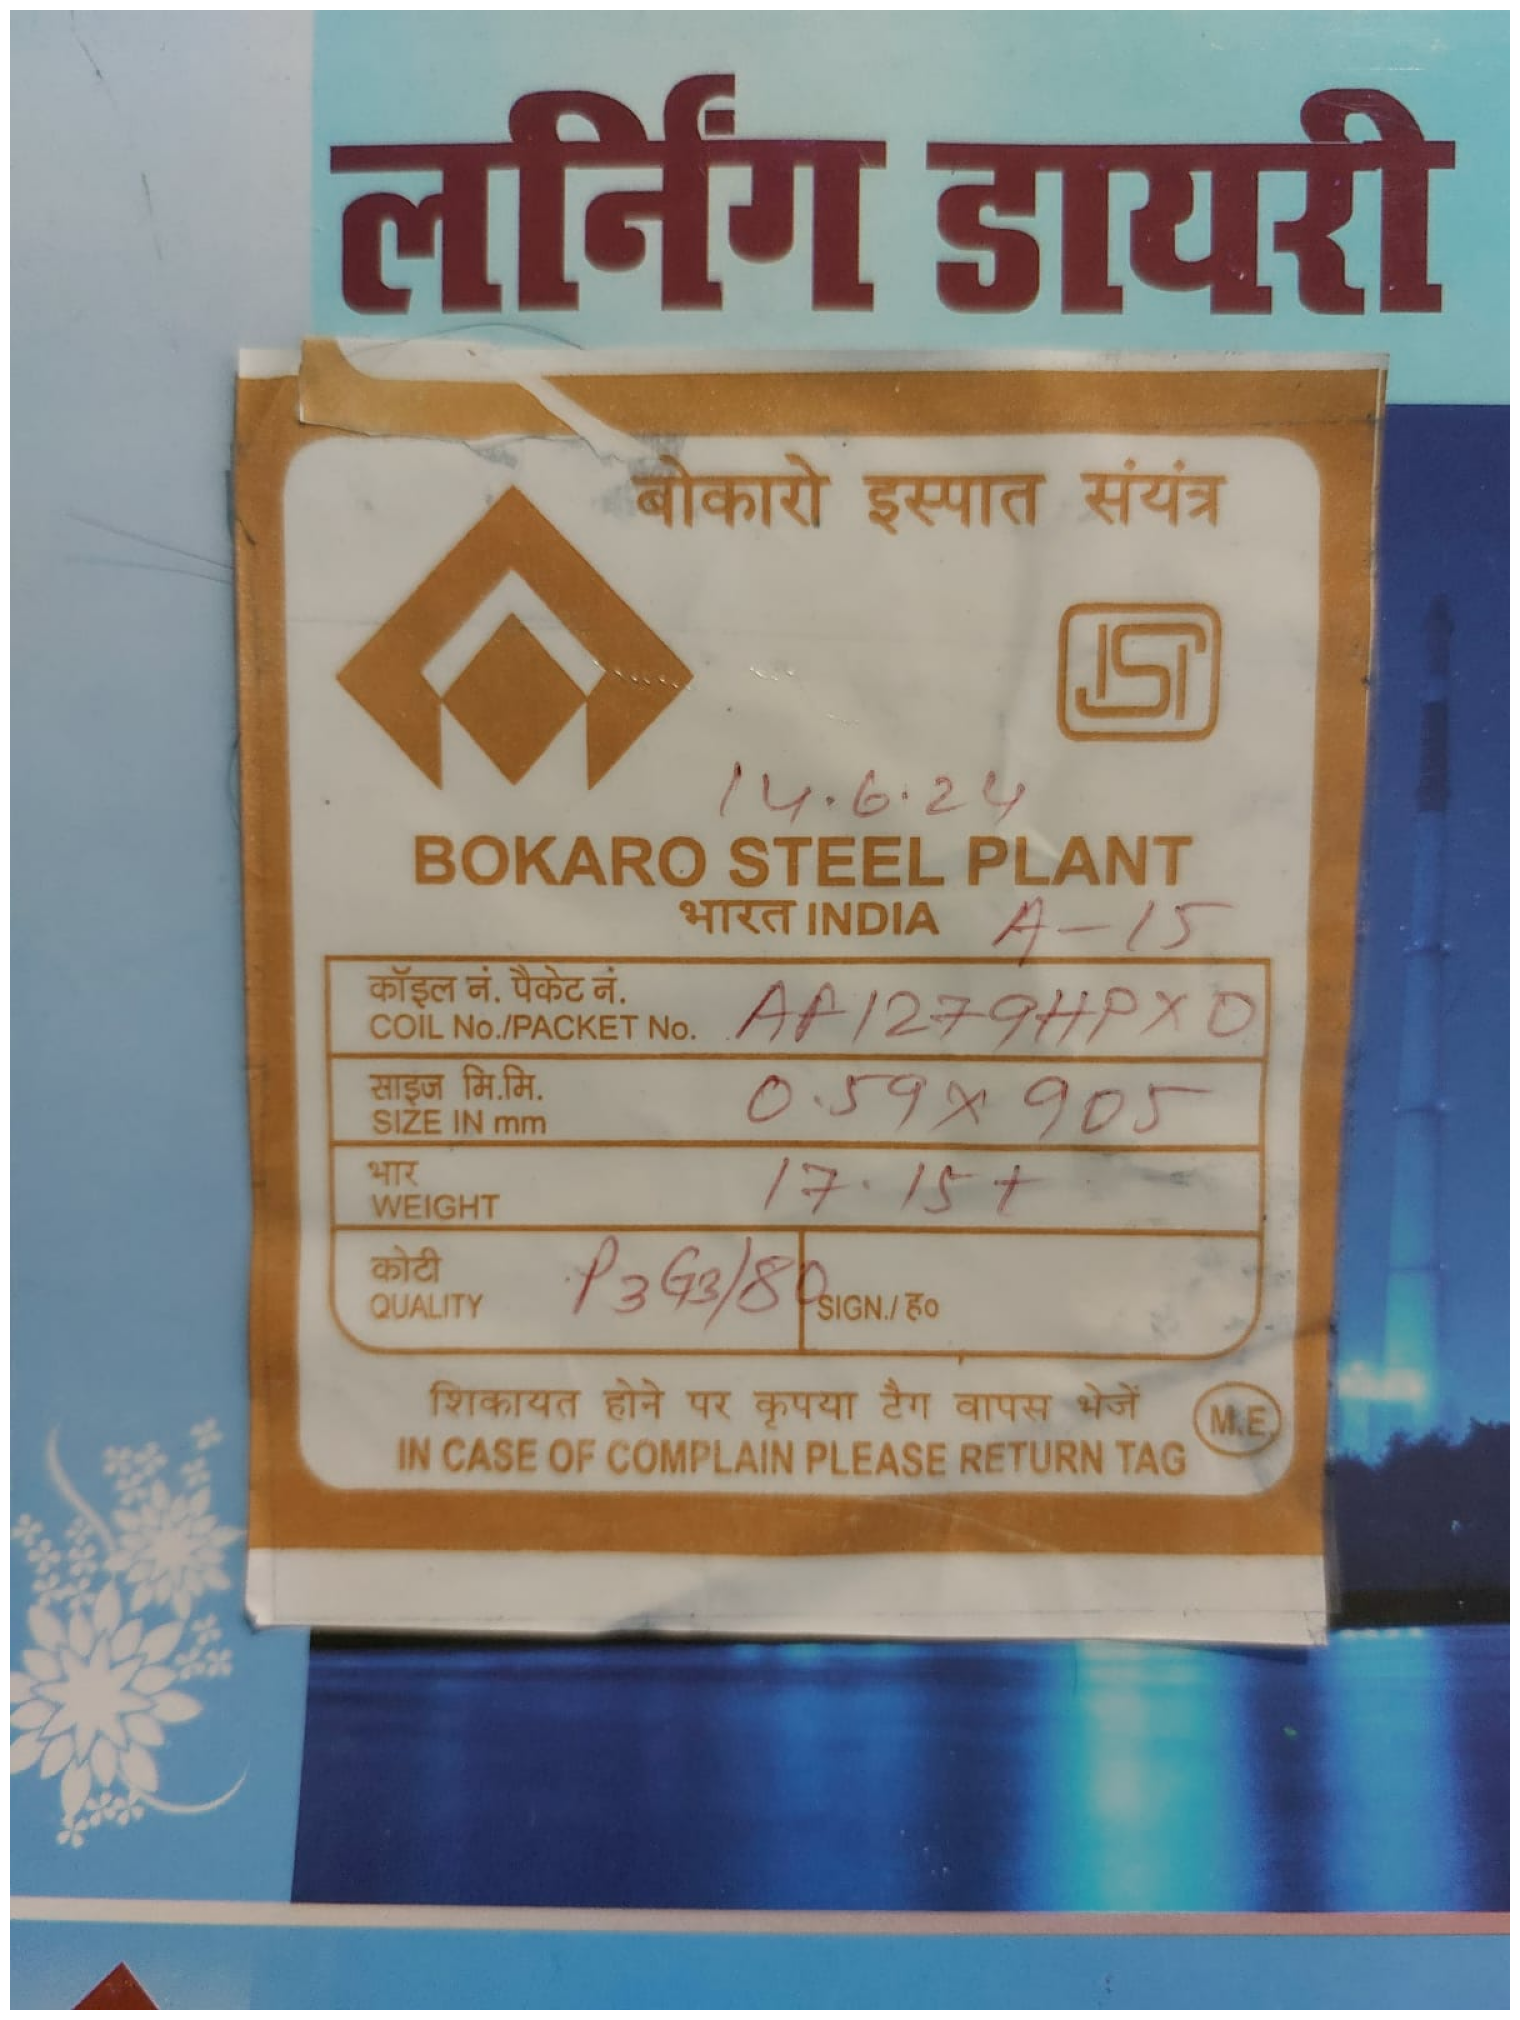

In [41]:
display(image)

In [43]:
reader = easyocr.Reader(['en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [49]:
cropped_images, dimensions = detect_and_crop_rectangular_pages(deskew_image(image))

In [61]:
final_images = []
arr = ["COIL", "SIZE", "WEIGHT"]
for image in cropped_images:
    res = reader.readtext(image)
    for a in arr:
        for detection in res:
            if a in detection[1]:
                final_images.append([image,a])
                arr.remove(a)
                break
        if a not in arr:
            break

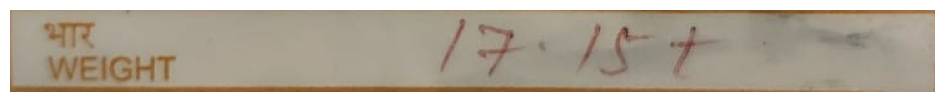

WEIGHT


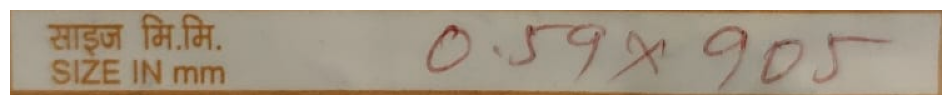

SIZE


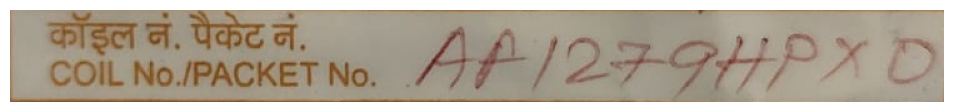

COIL


In [64]:
for image in final_images:
    display(image[0])
    print(image[1])

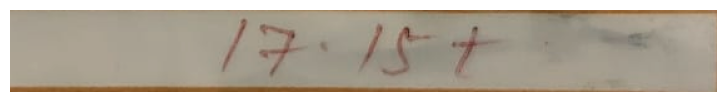

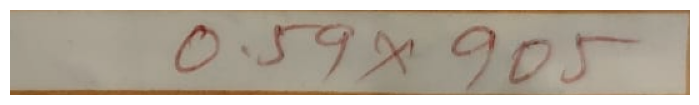

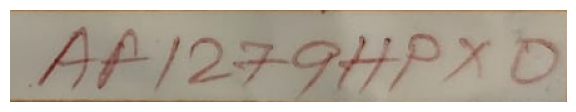

In [83]:
final1 = []
for image in final_images:
    h = image[0].shape[0]
    w = image[0].shape[1]
    if image[1] == "COIL":
        coil_crop = image[0][:,int((300/740)*w):w]
        display(coil_crop)
        final1.append([coil_crop,"COIL"])
    if image[1] == "SIZE":
        size_crop = image[0][:,int((200/740)*w):w]
        display(size_crop)
        final1.append([size_crop,"SIZE"])
    if image[1] == "WEIGHT":
        weight_crop = image[0][:,int((175/740)*w):w]
        display(weight_crop)
        final1.append([weight_crop,"WEIGHT"])

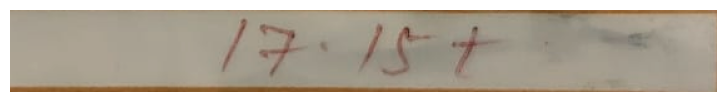

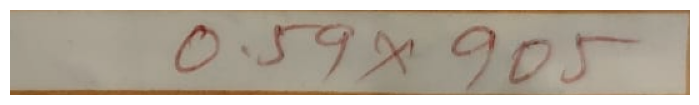

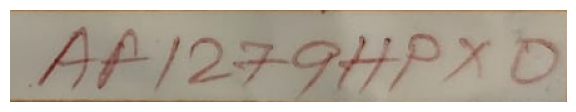

In [84]:
for image in final1:
    display(image[0])

In [87]:
result = []
for image in final1:
    gray = cv2.cvtColor(image[0], cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 3)
    r = reader.readtext(blur)
    for d in r:
        result.append([image[1], d[1]])
        print(d[1])

13.St
Jix 905
Af12+9#PX 0
